# IMU time stamp characterization

This notebook aims at observing and analyzing the time stamps provided by the sensors on board the IMU on an OAK camera from luxonis.

Histograms and time domain plots help in this endeavour and average sampling frequency is evaluated.

Few notes:
Histogram
This method uses numpy.histogram to bin the data in x and count the number of values in each bin, then draws the distribution either as a BarContainer or Polygon. The bins, range, density, and weights parameters are forwarded to numpy.histogram.
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist

In [1]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

HOME = os.getenv("HOME")
#CSV_FILENAME = 'imu_oakdpro_1hr_28032024.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_level.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_xUp.csv'

# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
PATH2FILE = HOME + '/Data/Drones/IMU/'
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_90mn_SR250_yUp' 
# old name: 'OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp'
MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_30mn_SR200_motorOn_29042024' 
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_60mn_SR200_motorOn_03052024' 
CSV_FILENAME = PATH2FILE + MEAS_FILENAME_NO_EXT + '.csv' 


# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zDown.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR100_accSR125.csv' 
# CSV_FILENAME = HOME+'/Data/Drones/IMU/imu_oak_BNO086_2hr_02042024.csv'
NOISE_PARAM_UNIT = 'rad'
PRECI= 2
TYPE = "e" # e: exponential notation
NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 100 # number of bins for the histogram
LOAD_SAMPLE = 'start' #all'

In [2]:
# get oak and imu versions from filenmae
oak_version = MEAS_FILENAME_NO_EXT.split('_')[0]
imu_version = MEAS_FILENAME_NO_EXT.split('_')[1]
print(oak_version)

OAKLight


In [3]:
# functions
# for FHWM
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [4]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [5]:
# Separate into arrays and select a slice of the input data
if LOAD_SAMPLE == 'all':
    acc_ts = dataArr[:, 0]  # time stamp for acceleration, second
    accx = dataArr[:, 1]  # m/s²
    accy = dataArr[:, 2]
    accz = dataArr[:, 3]
    ts = dataArr[:, 4]  # time stamp, second
    gx = dataArr[:, 5]  # (rad/s)
    gy = dataArr[:, 6]
    gz = dataArr[:, 7]
elif LOAD_SAMPLE == 'start':
    acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
    accx = dataArr[:NB_SAMPLE, 1]  # m/s²
    accy = dataArr[:NB_SAMPLE, 2]
    accz = dataArr[:NB_SAMPLE, 3]
    ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
    gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
    gy = dataArr[:NB_SAMPLE, 6]
    gz = dataArr[:NB_SAMPLE, 7]
elif LOAD_SAMPLE == 'end':
    acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
    accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
    accy = dataArr[-NB_SAMPLE:, 2]
    accz = dataArr[-NB_SAMPLE:, 3]
    ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
    gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
    gy = dataArr[-NB_SAMPLE:, 6]
    gz = dataArr[-NB_SAMPLE:, 7]

In [6]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'total number of samples: {tot_nb_sample}')

total number of samples: 360000


In [7]:
acc_ts_grad=np.gradient(acc_ts) 
# acc_ts_grad=np.gradient(acc_ts[1:]) # remove the first sample which is off
gyro_ts_grad=np.gradient(ts)
print(len(acc_ts_grad))
# idx_high_ts = np.where(acc_ts_grad < 1.0)
# print(idx_high_ts)
# print(f'{acc_ts_grad}')
# plt.hist(acc_ts_grad,NBINS)

1000


Note:

In some data samples, the accelerometer time stamp has an 'outlier' at the last bin.

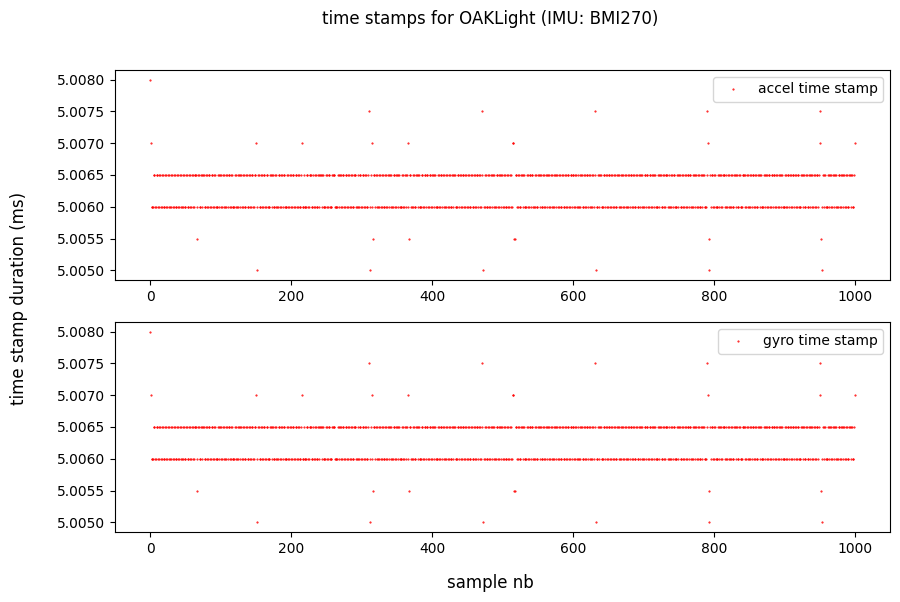

In [8]:
# idx_non0bin_ts = np.where(acc_ts_grad > 12.0)
# print(idx_high_ts)
f, axarr = plt.subplots(2, figsize=(10,6),sharex=False)
# f.set_figheight(12)
# f.set_figwidth(8)
f.suptitle(f'time stamps for {oak_version} (IMU: {imu_version})',fontsize = 12)
axarr[0].plot(acc_ts_grad, 'r.',markersize = 1,label='accel time stamp') 
axarr[1].plot(gyro_ts_grad, 'r.',markersize = 1,label='gyro time stamp') 
# axarr[0].set_ylabel('timestamp duration (ms)')
axarr[0].legend()
axarr[1].legend()
f.supxlabel('sample nb')
f.supylabel('time stamp duration (ms)')
f.savefig('timestamp_oaklight_bmi270_fs250.png')

[24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 93]
24 94
acc_cnt [    2.     4.     5.    17.   115.   600.  1621.  3308.  2461.  3004.
  4292.  8517.  4572.  6298.  5463.  5537.  2976.  3543.  2695.  4769.
  1827.   327.     3.     4.     0.     0.     1.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.    10.    58.   473.  1751.
  2208.  2333.  4102.  5874. 22769.  8668.  7753.  5768.  6808.  2955.
  3358.  3129.  2681.   969.   300.    34.     7.     9.     1.     1.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     2.
     1.     2.     1.     0.     3.     3.     3.     1.     3.     1.]
,bins_acc_ts [1.573 1.598 1.623 1.647 1.672 1.697 1.722 1.746 1.771 1.796 1.821 1.845
 1.87  1.895 1.92  1.944 1.969 1.994 2.019 2.044 2.068 2.093 2.

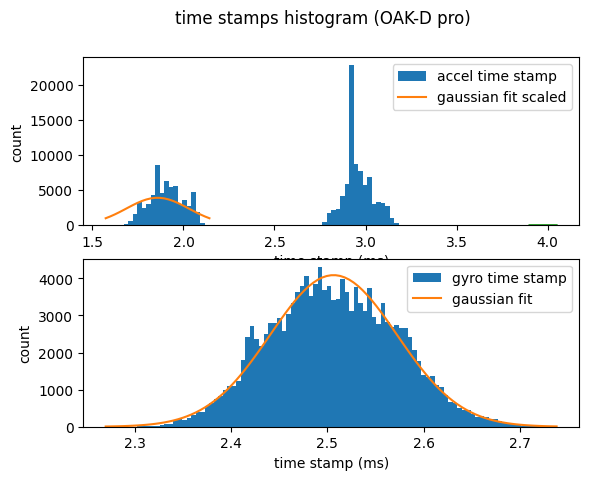

In [13]:
f, axarr = plt.subplots(2, sharex=False)
# f.set_figheight(12)
# f.set_figwidth(8)
f.suptitle(f'time stamps histogram (OAK-D pro)',fontsize = 12)
acc_cnt, bins_acc_ts, b = axarr[0].hist(acc_ts_grad, NBINS , density=False, label='accel time stamp') # alpha=0.1 is the opacity (alpha in 0 - 1 range)
gyr_cnt, bins_gyro_ts, _ = axarr[1].hist(gyro_ts_grad, NBINS, density=False, label='gyro time stamp') #, density=1, alpha=0.5,label='gyro time stamp')

# split the time stamp histo of the slowest sensor (the one with the smallest sampling rate)
idx_bin_0_ts = np.where(acc_cnt == 0.0)[0]
print(idx_bin_0_ts)
idx_low_bins_ts = idx_bin_0_ts[0] # end index for which the histo count is not zero (lower ts)
idx_hi_bins_ts = idx_bin_0_ts[-1]+1 # start index from which the histo count is not zero (higher ts)
# print(idx_bin_0_ts,idx_low_bins_ts,idx_hi_bins_ts)
print(idx_low_bins_ts,idx_hi_bins_ts)

bins_acc_low_ts = bins_acc_ts[:idx_low_bins_ts]
bins_acc_hi_ts = bins_acc_ts[idx_hi_bins_ts:]

cnt_acc_low_ts = acc_cnt[:idx_low_bins_ts]
cnt_acc_hi_ts = acc_cnt[idx_hi_bins_ts:]
# print(idx_hi_bins_ts)
# print(bins_acc_low_ts, bins_acc_hi_ts, acc_cnt[idx_hi_bins_ts])
# pouet

with np.printoptions(precision=3, suppress=True):
    print(f'acc_cnt {acc_cnt}\n,bins_acc_ts {bins_acc_ts}\n b {b}')
    print(f'gyr_cnt = {gyr_cnt},\nbins_gyro_ts {bins_gyro_ts}')
'''
# axarr[0].set_title('Gyro Angular rate X')
accel_expectd_fit=(1.7,.06,100,3,0.06,200)
# Create an array of length num_bins containing the center of each bin.

centers = 0.5*(bins_acc_ts[:-1] + bins_acc_ts[1:])
acc_params,acc_cov=curve_fit(bimodal,acc_cnt,centers,accel_expectd_fit)

# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(gyro_ts_grad)),gyro_ts_grad,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(acc_ts_grad)),acc_ts_grad,expected)
acc_sigma=np.sqrt(np.diag(acc_cov))
print(f'acc_params {acc_params} ,{acc_sigma}')  

gyro_expectd_fit=(2.5,.06,70)
# Create an array of length num_bins containing the center of each bin.
gyro_bin_centers = 0.5*(bins_gyro_ts[:-1] + bins_gyro_ts[1:])
gyr_params,gyr_cov=curve_fit(gauss,gyr_cnt,gyro_bin_centers,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(gyro_ts_grad)),gyro_ts_grad,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(acc_ts_grad)),acc_ts_grad,expected)
gyr_sigma=np.sqrt(np.diag(gyr_cov))
print(f'gyr_params {gyr_params} ,{gyr_sigma}')  
# params,cov=curve_fit(bimodal,bins_acc_ts,expected)
# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
'''
'''
# yet another way for the fit
from scipy.optimize import leastsq
# fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)+p[3]
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))
init  = [1.0, 0.5, 0.5]
# init  = [1.0, 0.5, 0.5, 0.5]
out   = leastsq( errfunc, init, args=(gyr_cnt,gyro_bin_centers))
c = out[0]
print("Fit Coefficients:")
print(c[0],c[1],abs(c[2]))
# print(c[0],c[1],abs(c[2]),c[3])
'''

mu, sigma = zip(stats.norm.fit(bins_acc_low_ts),stats.norm.fit(bins_acc_hi_ts),stats.norm.fit(gyro_ts_grad))
mu_lowts, sigma_lowts = stats.norm.fit(acc_ts_grad)


print(f'Gaussian best fit mu, sigma = {mu,sigma}\nlower FS ts: {mu_lowts,sigma_lowts})')
# gauss_fit_accts = stats.norm.pdf(bins_acc_ts, mu[0], sigma[0])
gauss_fit_accts_low_ts = stats.norm.pdf(bins_acc_low_ts, mu[0], sigma[0])
gauss_fit_accts_hi_ts = stats.norm.pdf(bins_acc_hi_ts, mu[1], sigma[1])
gauss_fit_gyrots =  stats.norm.pdf(bins_gyro_ts, mu[2], sigma[2])
# gauss_fit_gyrots = 1/sigma[1]* stats.norm.pdf(bins_gyro_ts, mu[1], sigma[1])
# axarr[0].plot(bins_acc_low_ts,gauss_fit_accts_low_ts,label = 'gaussian fit')
axarr[0].plot(bins_acc_low_ts,sum(cnt_acc_low_ts)*gauss_fit_accts_low_ts/sum(gauss_fit_accts_low_ts),label = 'gaussian fit scaled')
axarr[0].plot(bins_acc_hi_ts,sum(cnt_acc_hi_ts)*gauss_fit_accts_hi_ts/sum(gauss_fit_accts_hi_ts))
# axarr[0].plot(bins_acc_ts,gauss_fit_accts,label = 'gaussian fit')
# axarr[0].plot(bins_acc_ts,bimodal(bins_acc_ts,*acc_params),'r+',label = 'bimodal fit')

# axarr[1].plot(bins_gyro_ts,1/sigma[1]*gauss_fit_gyrots,label = 'gaussian fit')
axarr[1].plot(bins_gyro_ts,sum(gyr_cnt)*gauss_fit_gyrots/sum(gauss_fit_gyrots),label = 'gaussian fit')
# axarr[1].plot(bins_gyro_ts, fitfunc(c, bins_gyro_ts))
# axarr[1].plot(bins_gyro_ts,gauss(bins_gyro_ts,*gyr_params),label = 'curve fit')
with np.printoptions(precision=3, suppress=True):
    print(f'gauss_fit_accts_low \n{gauss_fit_accts_low_ts}')
    # print(f'gauss_fit_accts \n{gauss_fit_accts}')
for i in range(2):
    # axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('time stamp (ms)')
    axarr[i].legend()
# print(dataArr.shape)
# f.savefig('test.png', bbox_inches='tight')

In [14]:
# average sampling time period (ts is in ms)
fs_actual = 1000 / mu[2]
print(f'average sampling period = {mu[2]:.2}ms \n'
      f'actual sampling frequency = {fs_actual}')

average sampling period = 2.5ms 
actual sampling frequency = 398.95853481403134


(array([ 1.,  0.,  0.,  0.,  1.,  5.,  1., 10., 13., 16., 47., 42., 55.,
       60., 90., 69., 71., 69., 74., 70., 66., 58., 58., 50., 22., 18.,
       17.,  8.,  3.,  6.]), array([2.276     , 2.28926667, 2.30253333, 2.3158    , 2.32906667,
       2.34233333, 2.3556    , 2.36886667, 2.38213333, 2.3954    ,
       2.40866667, 2.42193333, 2.4352    , 2.44846667, 2.46173333,
       2.475     , 2.48826667, 2.50153333, 2.5148    , 2.52806667,
       2.54133333, 2.5546    , 2.56786667, 2.58113333, 2.5944    ,
       2.60766667, 2.62093333, 2.6342    , 2.64746667, 2.66073333,
       2.674     ]), <BarContainer object of 30 artists>)


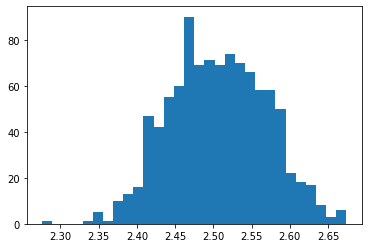

In [61]:
gyro_ts_grad=np.gradient(ts)
# print(f'{np.gradient(acc_ts)}')
a=plt.hist(gyro_ts_grad,NBINS)
print(a)
# print(dataArr.shape)

In [15]:
print(f'average sampling period accelerometer: {np.average(acc_ts_grad):.3}ms')
print(f'average sampling period gyroscope: {np.average(gyro_ts_grad):.3}ms')

average sampling period accelerometer: 2.51ms
average sampling period gyroscope: 2.51ms


In [17]:
# print(f'{acc_ts,ts}')